In [1]:
import pandas_datareader.data as web
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#Number of simulations
num_simulations = 1000
#Number of years
num_years = 5

# Import data & create dataframe

In this exercise two datasets will be used. The first one includes historic revenue growth, GDP growth and inflation while the second includes five-year forecasts for GDP growth and inflation. The historic figures where extracted from Fever-Tree annual accounts and the office of national statistics while the forecasted from the September 2020 PWC UK Economic Update.

In [3]:
#read historic data
df = pd.read_csv('data.csv',header=None)
df.columns=['revenue','%gdp_growth','%inflation']
#read forecasted data
df_fct = pd.read_csv('data_fct.csv',header=None)
df_fct.columns=['%gdp_growth_fct_vs','%inflation_fct_vs','%gdp_growth_fct_ls','%inflation_fct_ls']

In [4]:
df

,revenue,%gdp_growth,%inflation
0,0.097304,0.015,0.018
1,0.395067,0.013,0.025
2,0.664476,0.019,0.027
3,0.725461,0.019,0.007
4,0.707993,0.024,0.004
5,0.488756,0.026,0.015
6,0.438395,0.021,0.026
7,0.350000,0.015,0.028
8,0.791045,0.015,0.045


In [5]:
df_fct

,%gdp_growth_fct_vs,%inflation_fct_vs,%gdp_growth_fct_ls,%inflation_fct_ls
0,0.018,0.0162,0.018,0.0162
1,0.018,0.0162,0.018,0.0162
2,0.018,0.0162,0.018,0.0162
3,0.101,0.0150,0.039,0.0120
4,-0.111,0.0050,-0.120,0.0050


# Linkage between GDP & inflation, and the revenue growth of Fevertree

A linear relationship is assumed between revenue growth, GDP growth & inflation. Revenue is the dependent variable while GDP growth and inflation are the independent variables. An other assumption is that there is no multicollinearity in the data, that means that GDP growth and inflation are not highly correlated with each other. 

Multiple linear regression is used to calculate the two coefficients (b1, b2) along and the intercept (b0).

$ y =b ₀+b ₁x ₁+b₂x₂+c$  

Where y is the revenue growth, b0 the intercept, b1 the coefficient for GDP growth and b2 the coefficient for inflation. After calculating the coefficients and the intercept the equation above becomes:

$revenue Growth = 24.92*gdp Growth + 5.62*inflation - 0.06$

In [6]:
# create linear regression object
mlr = LinearRegression()

In [7]:
# fit linear regression
mlr.fit(df[['%gdp_growth', '%inflation']], df['revenue'])

LinearRegression()

In [8]:
intercept = mlr.intercept_
coefficients = mlr.coef_
gdp_coef = coefficients[0]
inf_coef = coefficients[1]

# Functions

In [9]:
def monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct):
    '''Performs the monte carlo simulation and returns a dataframe'''
    simulation_df = pd.DataFrame()
    for x in range(num_simulations):
        count = 0

        ebitda_series = []
        revenue_series = []
        gdp_growth = np.random.normal(loc = gdp_mean, scale = gdp_std)
        inflation = np.random.normal(loc = inf_mean, scale = inf_std)
        revenue_growth = gdp_coef*gdp_growth + inf_coef*inflation
        revenue = last_revenue*(1+revenue_growth)
        revenue_series.append(revenue)
        ebitda = revenue*ebitda_pct
        ebitda_series.append(ebitda)

        for y in range(num_years):
            if count==num_years-1:
                break
            gdp_growth = np.random.normal(loc = gdp_mean, scale = gdp_std)
            inflation = np.random.normal(loc = inf_mean, scale = inf_std)
            revenue_growth = gdp_coef*gdp_growth + inf_coef*inflation
            revenue = revenue_series[count]*(1+revenue_growth)
            revenue_series.append(revenue)
            ebitda = revenue*ebitda_pct
            ebitda_series.append(ebitda)
            count+=1
        simulation_df[x] = ebitda_series
        
    return simulation_df

In [10]:
def createPlot(simulation_df):
    ''' Creates a plot'''
    fig = plt.figure()
    fig.suptitle('Monte Carlo Simulation Fever-Tree')
    plt.plot(simulation_df)
    plt.axhline(y=last_ebitda,color='r',linestyle='-')
    plt.xlabel('Years')
    plt.ylabel('EBITDA')
    plt.show()

# Scenario_1 - Covid didn't Happen

The first scenario assumes that covid did not occur and as a result there is no major fluctuations in UK economy. The following assumptions are used:

* GDP Growth follows a normal distribution with mean equal to 1.8% and a standard deviation equal to 0.44% (based on past 9 years GDP growth). 
* Inflation follows a normal distribution with mean 2.1% and standard deviation of 1.2% (based on inflation of the past 9 years)
* EBITDA as a percentage of revenues is always the same and equal to 31.52% (average EBITDA of fever-tree the last 7 years)
* There is no correlation between gdp growtn and inflation.

In [11]:
# standard deviation of gdp growth and inflation
gdp_std = df['%gdp_growth'].std()
inf_std = df['%inflation'].std()
#mean of gdp and inflation
gdp_mean = df['%gdp_growth'].mean()
inf_mean = df['%inflation'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.3152
#last EBITDA
last_ebitda = 77.00

In [12]:
simulation_df_sc1 = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [13]:
# 5 years projection(rows) 1000 simulations (columns)
simulation_df_sc1

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,146.928012,138.816398,140.659000,125.418736,143.297872,155.357542,143.515519,140.024839,149.566722,140.989028,...,146.135379,127.906528,129.718782,126.272640,120.530573,136.576292,133.787979,122.126259,134.849127,133.387149
1,264.863743,187.896522,214.563553,212.923122,242.783042,231.209818,213.327197,202.728433,246.920545,215.502599,...,238.001303,228.724200,197.990014,185.298934,205.237619,220.095525,206.569469,200.201067,199.714570,229.550301
2,368.789485,313.498151,330.835092,327.654750,440.877472,339.898349,341.330653,324.647044,396.990466,349.138520,...,400.103729,379.868658,334.736697,262.637009,330.529604,310.633152,328.020565,341.195753,313.799987,393.252700
3,696.442038,537.381195,517.084091,564.299082,726.259148,500.858947,574.928886,528.216185,467.969744,576.973943,...,625.205644,615.124640,609.489567,442.654503,557.978822,512.451612,420.922097,625.623453,527.178755,519.965185
4,901.251161,924.384559,793.573404,948.162305,1112.551930,892.007683,1028.443257,851.042486,717.028235,901.577165,...,858.884011,999.099121,872.807168,654.974568,865.264886,787.633822,720.431128,1012.229677,922.274813,875.136652


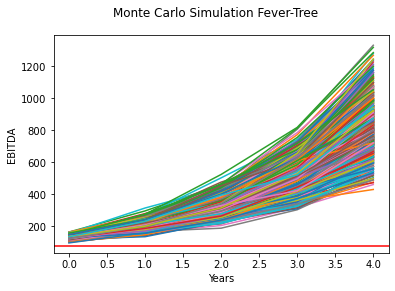

In [14]:
createPlot(simulation_df_sc1)

# Scenario_2 - Covid did Happen - VShaped Recession

The second scenario assumes a major recession in UK economy in 2020, a sharp recovery in 2021 and steady growth thereafter. The GDP growth and inflation forecasts for 2020 and 2021 were obtained from the September PWC UK Economic Update. The GDP growth and inflation for 2022, 2023 and 2024 is assumed to be equal to the average of the last 5 years which signals a return to normality in the medium to long term. The following assumption are used:

* GDP Growth follows a normal distribution with mean equal to 0.8% and a standard deviation equal to 7.6% (based on 5 years forecasted Vshaped GDP growth). 
* Inflation follows a normal distribution with mean 1.3% and standard deviation of 0.4% (based on 5 years forecasted Vshaped inflation).
* EBITDA as a percentage of revenues is always the same and equal to 31.52% (average EBITDA of fever-tree the last 7 years).
* There is no correlation between gdp growtn and inflation.

In [15]:
# standard deviation of gdp growth and inflation
gdp_std = df_fct['%gdp_growth_fct_vs'].std()
inf_std = df_fct['%inflation_fct_vs'].std()
#mean of gdp and inflation
gdp_mean = df_fct['%gdp_growth_fct_vs'].mean()
inf_mean = df_fct['%inflation_fct_vs'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.3152
#last EBITDA
last_ebitda = 77.00

In [16]:
simulation_df_sc2 = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [17]:
# 5 years projection(rows) 1000 simulations (columns)
simulation_df_sc2

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,75.374478,262.909787,162.509823,111.794431,320.357733,178.008852,-0.068249,68.221507,131.517177,401.733262,...,-31.072169,253.418771,88.047344,-140.440516,191.750632,-108.447089,119.626562,330.229253,21.399315,109.614691
1,1.714534,95.708456,555.345730,183.567288,1399.237652,516.197672,0.158970,74.054001,536.516349,337.390255,...,-63.880953,538.004251,105.912541,-80.389281,666.841622,460.503704,-52.196593,-51.359525,45.161083,311.372381
2,2.317980,372.963683,-33.039337,505.924929,-753.602028,99.776928,0.062186,51.179404,-58.443476,-1294.453517,...,172.757579,-34.151700,258.531399,-50.990544,1153.611326,608.901281,-256.060505,-96.210120,53.598980,435.913522
3,7.785280,535.249469,-163.424013,620.457600,-3888.908673,30.242107,0.138839,-50.925072,-162.256045,-6915.636886,...,84.349934,-92.609053,1478.826924,-121.896823,1952.945679,512.790350,-1362.190446,-95.249208,11.100948,1232.170689
4,-11.692163,-42.899331,30.164486,718.438952,-1171.719725,6.420270,0.191606,-22.099627,-273.545790,-11418.796266,...,-128.490225,-257.683152,268.832779,93.021307,-1066.947228,-419.165555,-1208.174730,-35.584608,1.402503,-1566.351141


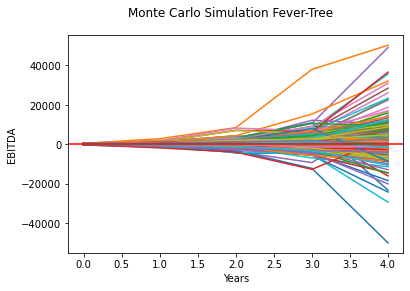

In [18]:
createPlot(simulation_df_sc2)

# Scenario_3 - Covid did Happen - LShaped Recession

The third scenario assumes a major recession in UK economy in 2020 and gradual recovery from 2021 onwards. The GDP growth and inflation forecasts for 2020 and 2021 were obtained from the September PWC UK Economic Update. I assumed a GDP growth and inflation for 2022, 2023 and 2024 will equal to the average of the last 5 years which signals a return to normality in the medium to long term. The following assumption are used:

* GDP Growth follows a normal distribution with mean equal to -0.53% and a standard deviation equal to 6.4% (based on 5 years forecasted Lshaped GDP growth). 
* Inflation follows a normal distribution with mean 1.3% and standard deviation of 0.48% (based on 5 years forecasted Lshaped inflation).
* EBITDA as a percentage of revenues is always the same and equal to 31.52% (average EBITDA of fever-tree the last 7 years).
* There is no correlation between gdp growtn and inflation.

In [19]:
# standard deviation of gdp growth and inflation
gdp_std = df_fct['%gdp_growth_fct_ls'].std()
inf_std = df_fct['%inflation_fct_ls'].std()
#mean of gdp and inflation
gdp_mean = df_fct['%gdp_growth_fct_ls'].mean()
inf_mean = df_fct['%inflation_fct_ls'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.3152
#last EBITDA
last_ebitda = 77.00

In [20]:
inf_std

0.004889989775040435

In [21]:
simulation_df_sc3 = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [22]:
# 5 years projection(rows) 1000 simulations (columns)
simulation_df_sc3

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-1.402850,28.573921,98.249679,72.848277,101.904321,-122.836153,265.434713,262.231511,76.031025,65.698937,...,-23.639401,188.918616,25.354615,197.892359,329.373177,144.244061,238.262366,-85.297828,75.966624,184.368766
1,-1.315096,14.781043,41.977290,49.124831,364.139618,-84.143305,185.071147,614.680374,145.900833,-18.314893,...,-21.881353,91.558644,43.089597,105.178478,484.811677,568.342526,-74.799225,-225.754783,296.405765,-12.485830
2,1.262890,41.550853,24.912566,150.971515,772.842027,-143.825187,-56.970648,631.762480,259.880618,-30.023167,...,-19.192756,-109.292897,-13.430045,40.046198,485.954960,-762.024425,-30.410892,-69.041720,46.576825,-46.940444
3,-1.913346,44.403093,13.627800,-51.496725,2480.636234,-83.780194,103.286948,95.104002,364.774888,-13.105215,...,5.804031,34.135932,-10.983784,44.074861,1176.270481,-2179.005158,-1.993757,-100.464979,121.118455,25.002773
4,4.487234,-20.370184,30.219439,-69.910160,1458.133591,-3.642170,182.459859,93.825234,583.383992,-8.289143,...,13.231328,-37.261757,-1.026877,46.774331,3766.301613,2275.722928,-1.616465,-92.011889,198.240380,80.365249


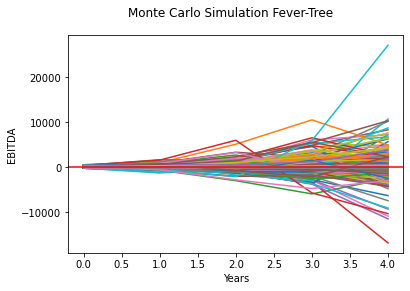

In [23]:
createPlot(simulation_df_sc3)

# Scenario_4 - Covid did Happen - LShaped Recession - Major Fixed costs

The forth scenario makes the same assumptions as scenario_3 in terms of gdp growth and inflation but this time it assumes that fever-tree has major fixed costs associated with cost of sales and as a result EBITDA as a % of sales is lower. The following assumption are used:

* GDP Growth follows a normal distribution with mean equal to -0.53% and a standard deviation equal to 6.4% (based on 5 years forecasted Lshaped GDP growth). 
* Inflation follows a normal distribution with mean 1.3% and standard deviation of 0.48% (based on 5 years forecasted Lshaped inflation)
* EBITDA as a percentage of revenues is always the same and equal to 20.00%.
* There is no correlation between gdp growtn and inflation.

In [47]:
# standard deviation of gdp growth and inflation
gdp_std = df_fct['%gdp_growth_fct_ls'].std()
inf_std = df_fct['%inflation_fct_ls'].std()
#mean of gdp and inflation
gdp_mean = df_fct['%gdp_growth_fct_ls'].mean()
inf_mean = df_fct['%inflation_fct_ls'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.20
#last EBITDA
last_ebitda = 77.00

In [48]:
simulation_df_sc4 = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [49]:
# 5 years projection(rows) 1000 simulations (columns)
simulation_df_sc4

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,182.284945,75.687145,-59.667496,99.888835,-22.276880,21.414914,61.741056,175.586513,160.418196,-61.591302,...,127.518738,-18.982413,109.888471,-70.853506,-31.549052,16.512492,42.772834,152.718240,97.409092,45.935031
1,724.309701,-46.328663,-92.663238,68.992221,-29.175890,5.371945,-16.374538,338.860947,484.268260,-11.477846,...,13.489547,-4.034458,1.811152,-178.922599,28.418104,-4.046495,67.445429,-252.967206,-41.370829,104.956729
2,-162.099679,-56.576062,-272.157142,322.009657,34.637035,12.811080,9.454688,497.937705,-295.221839,7.241079,...,-3.533370,-1.271312,1.607351,56.264072,98.333819,0.635872,41.959212,-389.424099,15.897548,-116.713306
3,124.592334,-134.202663,170.577959,696.756323,38.434164,36.703554,28.652137,25.833893,-480.342108,-0.477656,...,1.678955,1.806450,1.762150,59.282222,189.780400,-2.034488,36.288556,753.776958,-19.415210,-9.373805
4,299.149503,484.922307,-448.411567,-353.629760,41.490082,55.510685,-37.862211,57.767885,-1836.476476,0.682029,...,2.001763,2.387547,2.744792,95.135193,-155.743928,-6.304211,67.189772,-318.825791,-23.965919,7.800324


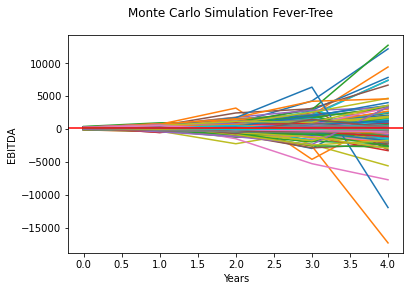

In [50]:
createPlot(simulation_df_sc4)

# Scenario_5 - Covid did Happen - VShaped Recession - Major Fixed costs

The forth scenario makes the same assumptions as scenario_2 in terms of gdp growth and inflation but this time it assumes that fever-tree has major fixed costs associated with cost of sales and as a result EBITDA as a % of sales is lower. The following assumption are used:

* GDP Growth follows a normal distribution with mean equal to 0.8% and a standard deviation equal to 7.6% (based on 5 years forecasted Vshaped GDP growth). 
* Inflation follows a normal distribution with mean 1.3% and standard deviation of 0.4% (based on 5 years forecasted Vshaped inflation)
* EBITDA as a percentage of revenues is always the same and equal to 20.00%.
* There is no correlation between gdp growtn and inflation.

In [51]:
# standard deviation of gdp growth and inflation
gdp_std = df_fct['%gdp_growth_fct_vs'].std()
inf_std = df_fct['%inflation_fct_vs'].std()
#mean of gdp and inflation
gdp_mean = df_fct['%gdp_growth_fct_vs'].mean()
inf_mean = df_fct['%inflation_fct_vs'].mean()
#last reported revenue in millions 
last_revenue  = 260.5
#EBITDA as % of revenue
ebitda_pct = 0.20
#last EBITDA
last_ebitda = 77.00

In [52]:
simulation_df_sc5 = monteCarloDataframe(num_simulations,num_years,gdp_mean,gdp_std,inf_mean,inf_std,gdp_coef,inf_coef,last_revenue,ebitda_pct)

In [53]:
# 5 years projection(rows) 1000 simulations (columns)
simulation_df_sc5

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-82.223117,163.993963,-49.676011,-54.101487,-13.904666,63.772746,186.547910,321.583423,49.498677,-8.502488,...,162.059593,121.131646,111.654137,125.905219,24.140219,44.650938,96.702602,99.409698,102.214753,262.122551
1,-187.141039,33.601111,-36.848104,-158.791122,4.722423,86.590848,-8.189125,-107.994944,63.611843,10.690082,...,448.686936,42.122794,207.533323,-112.251809,80.802872,46.191390,197.704224,-192.120872,-23.244586,838.072076
2,-911.052035,73.622932,23.080901,-340.813499,11.234717,-190.016971,-12.045744,3.938158,199.912368,-7.018251,...,750.543158,-26.925653,293.409446,216.711201,201.178061,84.465836,-172.854554,-484.550267,21.927002,1614.219469
3,-3517.035000,247.323412,74.474789,355.540530,49.891595,14.647314,16.698073,4.419168,277.424506,-13.218161,...,918.108727,108.000354,-110.247022,531.067828,-290.819805,161.497347,-455.395241,-1003.985090,62.740431,1227.099405
4,-14074.861784,-98.012273,121.582024,1106.483402,-65.337834,13.707510,28.787628,14.712778,106.762784,26.609470,...,-1848.680737,-138.611998,-43.992927,-160.379946,-990.805054,406.183957,35.726906,-4468.049255,88.665542,1944.304959


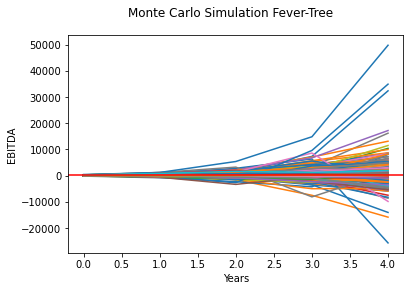

In [54]:
createPlot(simulation_df_sc5)

# Statistics

## Scenario_1  - Year 5 EBITDA Projections

### Key observations
* In 50% of projections EBITDA takes values between 716m and 917m
* The mean is 823m and the median 811m which suggests that the distribution of our data is slightly positively skewed.

In [70]:
simulation_df_sc1_tr = simulation_df_sc1.transpose()
simulation_df_sc1_tr.columns = [2020,2021,2022,2023,2024]

<AxesSubplot:>

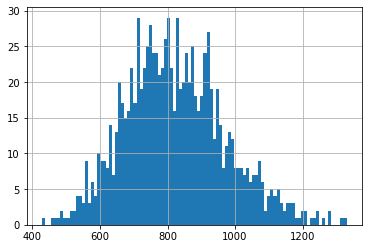

In [71]:
simulation_df_sc1_tr[2024].hist(bins=100)

In [72]:
simulation_df_sc1_tr[2024].describe()

count    1000.000000
mean      823.222925
std       149.220028
min       428.723042
25%       716.940842
50%       811.775768
75%       917.301932
max      1330.252320
Name: 2024, dtype: float64

## Scenario_2  - Year 5

### Key observations
* In 50% of projections EBITDA takes values between -268m and 321m
* The mean is 411m and the media close to zero which suggests that the distribution of our data is heavily positively skewed.

In [73]:
simulation_df_sc2_tr = simulation_df_sc2.transpose()
simulation_df_sc2_tr.columns = [2020,2021,2022,2023,2024]

<AxesSubplot:>

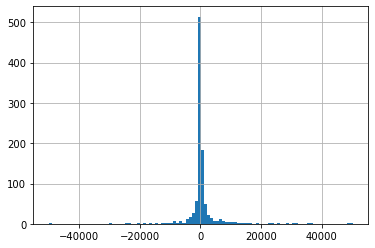

In [74]:
simulation_df_sc2_tr[2024].hist(bins=100)

In [75]:
simulation_df_sc2_tr[2024].describe()

count     1000.000000
mean       411.161522
std       5160.989425
min     -50062.833905
25%       -268.580825
50%          0.154580
75%        321.136302
max      50259.000739
Name: 2024, dtype: float64

## Scenario_3 - Year 5

### Key observations
* In 50% of projections EBITDA takes values between -93m and 138m
* The mean is 93m and the median close to zero which suggests that the distribution of our data is heavily positively skewed.

In [61]:
simulation_df_sc3_tr = simulation_df_sc3.transpose()
simulation_df_sc3_tr.columns = [2020,2021,2022,2023,2024]

<AxesSubplot:>

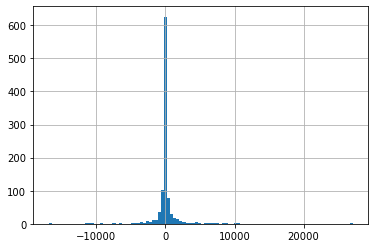

In [62]:
simulation_df_sc3_tr[2024].hist(bins=100)

In [63]:
simulation_df_sc3_tr[2024].describe()

count     1000.000000
mean        93.073725
std       1809.823198
min     -16889.932688
25%        -93.657011
50%          0.723803
75%        138.674970
max      27118.602464
Name: 2024, dtype: float64

## Scenario_4 - Year 5

### Key observations
* In 50% of projections EBITDA takes values between -59m and 98m
* The mean is 62m and the median close to zero.

In [80]:
simulation_df_sc4_tr = simulation_df_sc4.transpose()
simulation_df_sc4_tr.columns = [2020,2021,2022,2023,2024]

<AxesSubplot:>

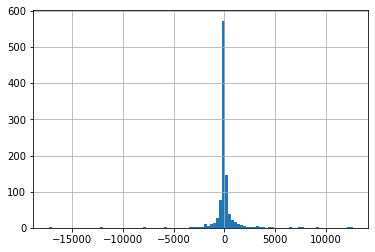

In [81]:
simulation_df_sc4_tr[2024].hist(bins=100)

In [82]:
simulation_df_sc4_tr[2024].describe()

count     1000.000000
mean        62.159737
std       1272.001803
min     -17334.350598
25%        -59.335874
50%          0.587432
75%         98.258924
max      12687.029018
Name: 2024, dtype: float64

## Scenario_5 - Year 5

### Key observations
* In 50% of projections EBITDA takes values between -166m and 260m
* The mean is 167m and the median 2.4m.

In [92]:
simulation_df_sc5_tr = simulation_df_sc5.transpose()
simulation_df_sc5_tr.columns = [2020,2021,2022,2023,2024]

<AxesSubplot:>

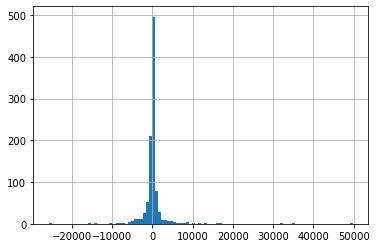

In [93]:
simulation_df_sc5_tr[2024].hist(bins=100)

In [94]:
simulation_df_sc5_tr[2024].describe()

count     1000.000000
mean       167.032579
std       3088.238358
min     -25716.860883
25%       -166.090074
50%          2.485985
75%        260.621362
max      49781.522072
Name: 2024, dtype: float64

# Conlusion & Limitation of Analysis

In this analysis multiple linear regression and Monte Carlo simulation were used to predict the EBITDA of Fever-Tree the next five years. Two predictors were used to estimate Fever-Tree's revenue growth. Namely GDP growth and inflation. It was assumed that a linear relationship exists between the independent (GDP growth, inflation) and the dependent (revenue growth) variables. Moreover, it was assumed that there is no correlation between GDP growth and inflation. Finally, it was assumed that EBITDA as a percentage of revenue is always the same. Five different scenarios were run to examine the effect of no recession, Vshaped recession, Lshaped recession on EBITDA predictions. All the results along with statistics are documented above.

The limitations of the analysis above are the following:
* Limited available data e.g. is 9 years historic and five years of forecasted data.
* Multiple linear regression requires at least 30 independent observations to estimate coefficients but due to lack of data only nine were used in this exercise.
* The standard deviation of historic data is not suitable for predicting future results e.g. the standard deviation of GDP Growth is expected to be much higher due to recession caused by covid.
* The forecasted standard deviation could produce extreme positive or negative EBITDA predictions when Monte Carlo simulation is used.
* GDP growth and inflation are assumed to have zero correlation which is reality could be not true.
* Only two predictors where used to estimate revenue growth e.g. GDP growth and Inflation. There are more predictors which could explain Fever-Tree’s revenue e.g. unemployment growth.
* The relation between revenue growth and the independent variables could be nonlinear. It would be interesting to experiment with a nonlinear model like nonlinear support vector regression.
* For simplicity EBITDA as a percentage of revenue was assumed to be always the same. In reality this is not true because cost of sales includes a mixture of fixed and variable costs.

